## Library

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, MultivariateNormalDistributionLoss

import pytorch_forecasting
import torch

In [67]:
torch.__version__

'1.11.0+cpu'

In [70]:
pytorch_forecasting.__version__

'0.10.2'

In [71]:
pl.__version__

'1.6.3'

## Data

In [2]:
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]


In [57]:
data = pd.read_csv('../dataset/sample_upbit_daydata.csv')

In [58]:
data.head()

,Unnamed: 0,ticker,open,high,low,close,volume,value
0,2022-01-29 09:00:00,KRW-BTC,46592000.0,47746000.0,46180000.0,47146000.0,3980.167762,1.862863e+11
1,2022-01-30 09:00:00,KRW-BTC,47144000.0,47500000.0,46498000.0,47208000.0,2868.985234,1.350271e+11
2,2022-01-31 09:00:00,KRW-BTC,47208000.0,47647000.0,45624000.0,47266000.0,4554.265206,2.112754e+11
3,2022-02-01 09:00:00,KRW-BTC,47304000.0,48270000.0,46869000.0,47760000.0,3944.001610,1.874350e+11
4,2022-02-02 09:00:00,KRW-BTC,47784000.0,47900000.0,45401000.0,45517000.0,4684.820468,2.192811e+11


In [60]:
# 100개 미만의 데이터가 있는 ticker는 삭제 

print(f'drop 전의 data shape: {data.shape}')
tmp = data.groupby('ticker').agg({'Unnamed: 0':'nunique'})
drop_ticker = tmp[tmp['Unnamed: 0'] < 100].index.values
print(drop_ticker)
 
drop_index = data[data['ticker'].isin(drop_ticker)].index.to_list()
data.drop(drop_index, inplace=True)
print(f'drop 후의 data shape: {data.shape}')

drop 전의 data shape: (11216, 8)
['KRW-AVAX' 'KRW-CELO' 'KRW-GMT' 'KRW-T']
drop 후의 data shape: (11000, 8)


<AxesSubplot:>

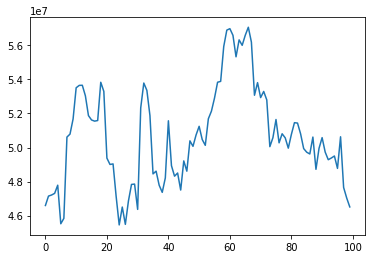

In [62]:
data[data['ticker']=='KRW-BTC']['open'].plot()

<AxesSubplot:>

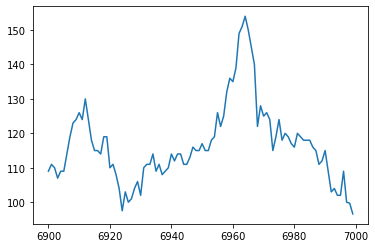

In [64]:
data[data['ticker']=='KRW-DKA']['open'].plot()

### timeseries dataset

In [81]:
# series, time_idx 열 추가 

add_data = pd.DataFrame(
    dict(
        series=np.repeat(np.arange(110), 100),
        time_idx=np.tile(np.arange(100), 110),
    )
)


data = pd.concat([data, add_data], axis=1)

In [83]:
data.head()

,Unnamed: 0,ticker,open,high,low,close,volume,value,series,time_idx
0,2022-01-29 09:00:00,KRW-BTC,46592000.0,47746000.0,46180000.0,47146000.0,3980.167762,1.862863e+11,0,0
1,2022-01-30 09:00:00,KRW-BTC,47144000.0,47500000.0,46498000.0,47208000.0,2868.985234,1.350271e+11,0,1
2,2022-01-31 09:00:00,KRW-BTC,47208000.0,47647000.0,45624000.0,47266000.0,4554.265206,2.112754e+11,0,2
3,2022-02-01 09:00:00,KRW-BTC,47304000.0,48270000.0,46869000.0,47760000.0,3944.001610,1.874350e+11,0,3
4,2022-02-02 09:00:00,KRW-BTC,47784000.0,47900000.0,45401000.0,45517000.0,4684.820468,2.192811e+11,0,4


In [85]:
data.groupby('series')['time_idx'].value_counts()

series  time_idx
0       0           1
        1           1
        2           1
        3           1
        4           1
                   ..
109     95          1
        96          1
        97          1
        98          1
        99          1
Name: time_idx, Length: 11000, dtype: int64

In [86]:
data = data.astype(dict(series=str))

In [235]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="open",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    static_categoricals=[
        "series"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=["open"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

## Model

In [236]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

c:\Users\82108\anaconda3\envs\torch_lightning\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\82108\anaconda3\envs\torch_lightning\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


tensor(0.0976)

In [237]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(gpus=0, gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training, learning_rate=3e-2, hidden_size=30, rnn_layers=2, loss=MultivariateNormalDistributionLoss(rank=30)
)

Global seed set to 42
c:\Users\82108\anaconda3\envs\torch_lightning\lib\site-packages\pytorch_lightning\loops\utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Train

c:\Users\82108\anaconda3\envs\torch_lightning\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\82108\anaconda3\envs\torch_lightning\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\82108\anaconda3\envs\torch_lightning\lib\site-packages\pytorch_lightning\trainer\trainer.py:1927: PossibleUserWarning: The number of training batches (1) is smalle

suggested learning rate: 0.39810717055349737


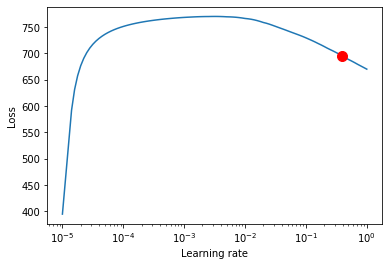

C:\Users\82108\AppData\Local\Temp\ipykernel_14576\174388251.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [238]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [239]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=300,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=0.1,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 2.4 K 
3 | rnn                    | LSTM                               | 14.0 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
17.5 K    Trainable params
0         Non-trainable params
17.5 K    Total params
0.070     Total estimated model params size (MB)


Epoch 57: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s, loss=555, v_num=4, train_loss_step=533.0, val_loss=725.0, train_loss_epoch=533.0]


In [240]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [241]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(23648.0391)

In [242]:
raw_predictions, x = net.predict(val_dataloader, mode="raw", return_x=True, n_samples=100)

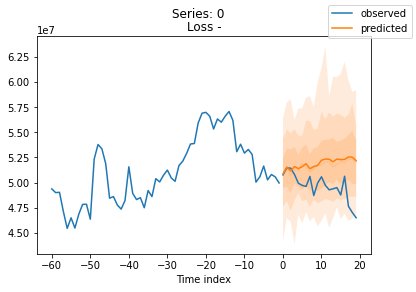

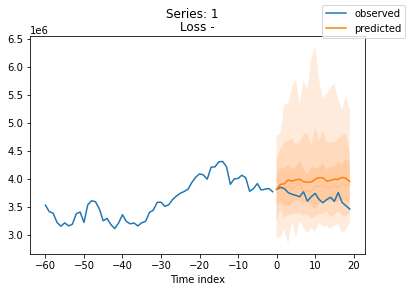

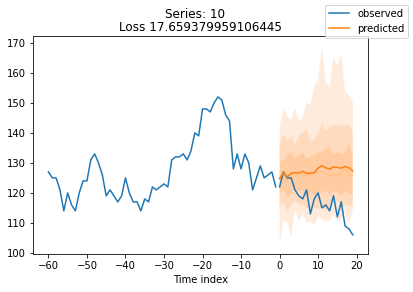

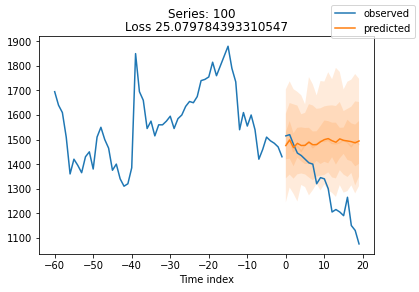

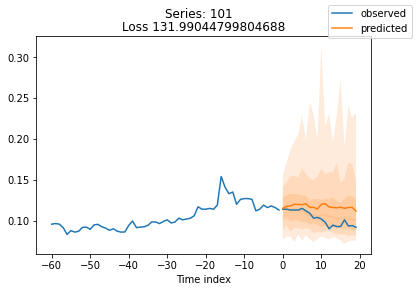

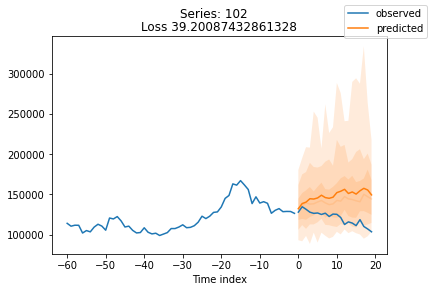

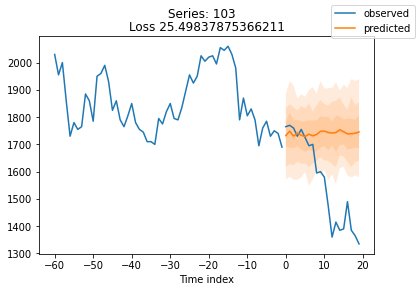

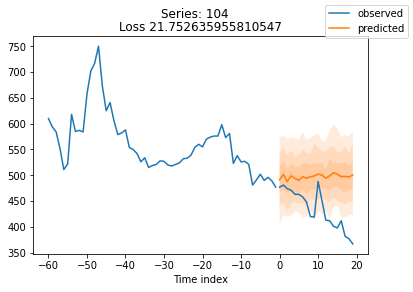

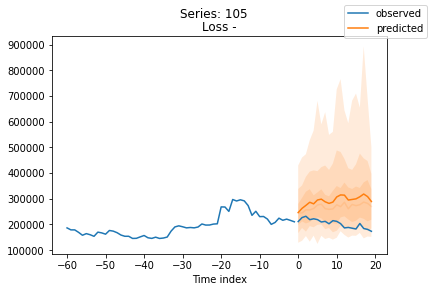

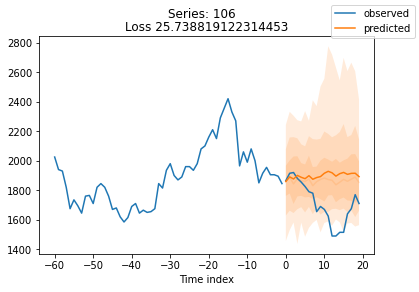

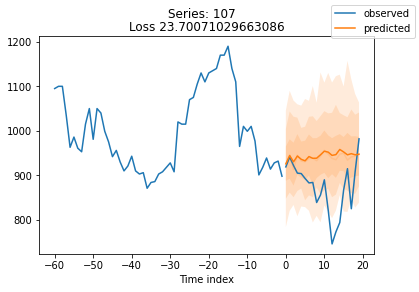

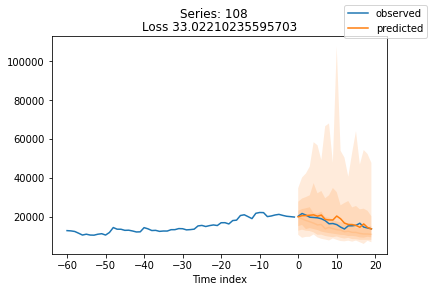

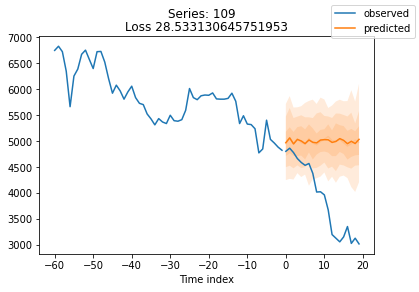

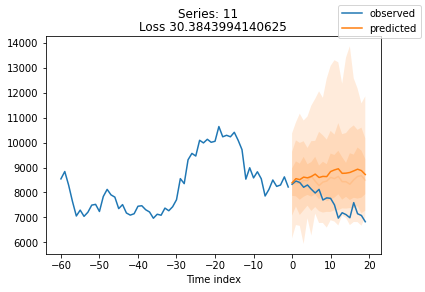

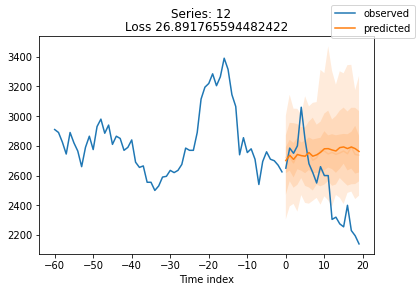

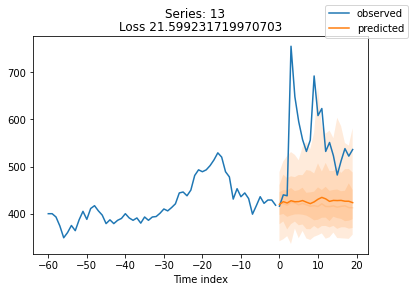

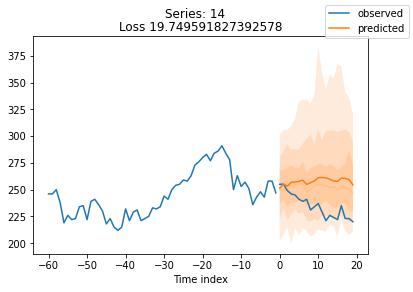

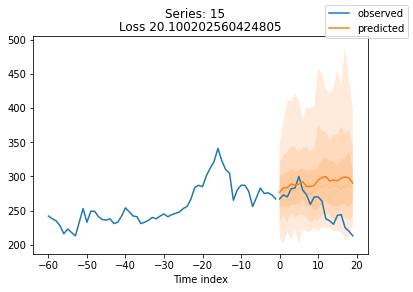

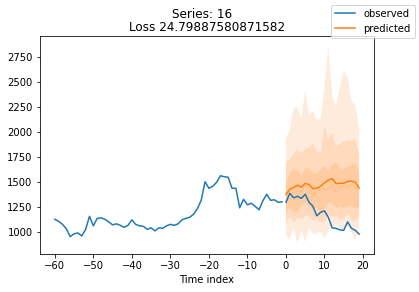

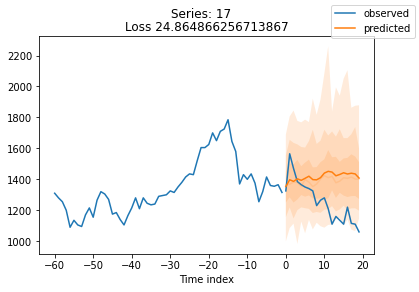

In [244]:
series = validation.x_to_index(x)["series"]
for idx in range(20):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")

In [245]:
data_test = pd.DataFrame(
    dict(
        series=np.repeat(np.arange(110), 80),
        time_idx=np.tile(np.arange(100, 180), 110),
    )
)

data_test['open'] = 0.
data_test = data_test.astype(dict(series=str))

In [246]:
data_test.head()

,series,time_idx,open
0,0,100,0.0
1,0,101,0.0
2,0,102,0.0
3,0,103,0.0
4,0,104,0.0


In [247]:
pred, x = net.predict(data_test, return_x=True)

c:\Users\82108\anaconda3\envs\torch_lightning\lib\site-packages\pytorch_forecasting\data\encoders.py:855: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
